In [28]:
import os
import pywt
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN
from src.attribution.wavelet.wavelet import WaveletFilterbank
from src.utils.sampling import downsample_wavedec, upsampling_wavedec

In [29]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [41]:
# set seed
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# load the model
model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# load the model weights
model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_4.pth", map_location=torch.device('mps')))
model.to(device)

Using device: mps


SimpleCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 2, kernel_size=(5,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)

In [42]:
set_seed(42)

# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_4"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Shuffle indices once
indices = torch.randperm(len(x))

# Apply the shuffle
x_shuffled = x[indices]
y_shuffled = y[indices]

# create the dataset
dataset = TensorDataset(x_shuffled, y_shuffled)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128)


(10000, 1, 1000)
(10000,)


In [43]:
attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

# prediction
for batch in test_loader:
    # get data
    x, y = batch
    x = x.to(device)
    output = model(x)

    predictions.append(output)
    labels.append(y)

# concatenat the predictions and the labels through the first dim
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)

In [44]:
correct = 0
for i in range(len(predictions)):
    if predictions[i].argmax() == labels[i]:
        correct += 1

print(f"Accuracy: {correct / len(predictions)}")

Accuracy: 1.0


In [45]:
print(predictions)

tensor([[ -9.9696,   9.8402],
        [ -8.3824,   8.2920],
        [  6.4731,  -6.3679],
        ...,
        [ -7.1108,   7.0427],
        [-10.2091,  10.0776],
        [ -9.9804,   9.8534]], device='mps:0', grad_fn=<CatBackward0>)


In [46]:
# save it in the attributions dict
attributions['predictions'] = predictions
attributions['labels'] = labels

In [47]:
def plot_fft(signal, fs):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title("FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

In [48]:
samples_0 = []
samples_1 = []

# get one batch
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()
    y = y.numpy()

    for i in range(len(x)):
        if y[i] == 0:
            samples_0.append(x[i][0])
        else:
            samples_1.append(x[i][0])

    break

print(len(samples_0))
print(len(samples_1))



61
67


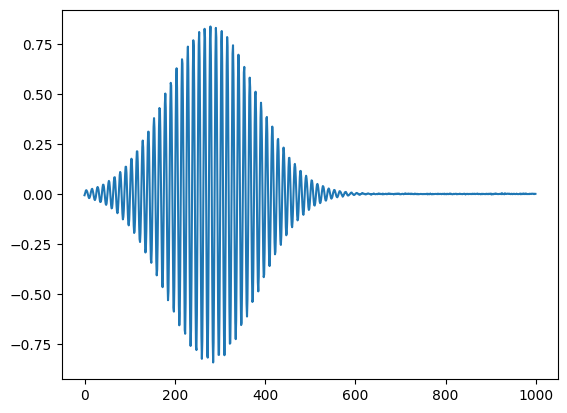

In [49]:
plt.plot(samples_0[0])

Time Uncertainty (Δt): 0.070614 s
Frequency Uncertainty (Δf): 80.095875 Hz
Uncertainty Product (Δt * Δf): 5.655864
Heisenberg Lower Bound (1/4π): 0.079577
Is product >= lower bound? True


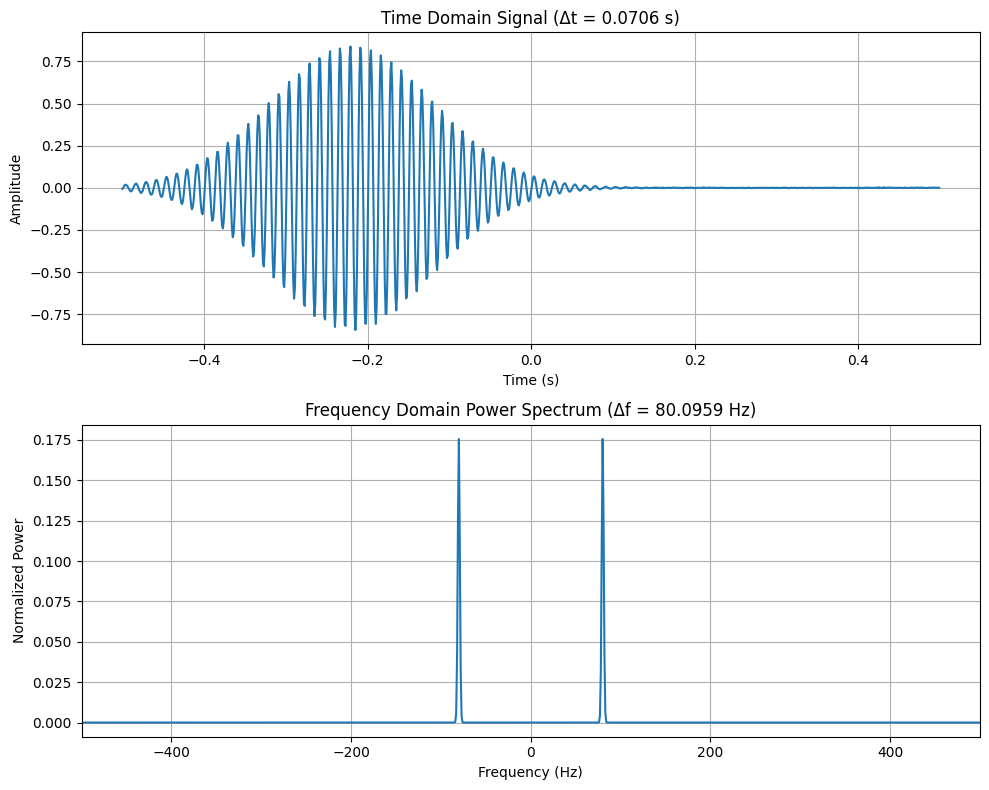

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Create a Gaussian signal (the "ideal" case)
fs = 1000  # Sampling frequency in Hz
N = 1000   # Number of samples
t = np.arange(-N/2, N/2) / fs  # Time vector centered around 0

# Gaussian parameters
# sigma_gauss = 0.05  # Controls the width of the Gaussian in time
# x = np.exp(-t**2 / (2 * sigma_gauss**2))

x = samples_0[0]

# --- A. COMPUTE TIME UNCERTAINTY (delta_t) ---
power_t = np.abs(x)**2
power_t /= np.sum(power_t)
mu_t = np.sum(t * power_t)
var_t = np.sum(((t - mu_t)**2) * power_t)
delta_t = np.sqrt(var_t)

# --- B. COMPUTE FREQUENCY UNCERTAINTY (delta_f) ---
X = np.fft.fft(x)
f = np.fft.fftfreq(N, d=1/fs)

power_f = np.abs(X)**2
power_f /= np.sum(power_f)

# Shift for correct mean calculation
f_shifted = np.fft.fftshift(f)
power_f_shifted = np.fft.fftshift(power_f)

mu_f = np.sum(f_shifted * power_f_shifted)
var_f = np.sum(((f_shifted - mu_f)**2) * power_f_shifted)
delta_f = np.sqrt(var_f)

# --- C. VERIFY THE UNCERTAINTY PRINCIPLE ---
uncertainty_product = delta_t * delta_f
lower_bound = 1 / (4 * np.pi)

print(f"Time Uncertainty (Δt): {delta_t:.6f} s")
print(f"Frequency Uncertainty (Δf): {delta_f:.6f} Hz")
print(f"Uncertainty Product (Δt * Δf): {uncertainty_product:.6f}")
print(f"Heisenberg Lower Bound (1/4π): {lower_bound:.6f}")
print(f"Is product >= lower bound? {uncertainty_product >= lower_bound}")

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(t, x)
ax1.set_title(f"Time Domain Signal (Δt = {delta_t:.4f} s)")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.grid(True)

ax2.plot(f_shifted, power_f_shifted)
ax2.set_title(f"Frequency Domain Power Spectrum (Δf = {delta_f:.4f} Hz)")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Normalized Power")
ax2.set_xlim(-500, 500)
ax2.grid(True)

plt.tight_layout()
plt.show()

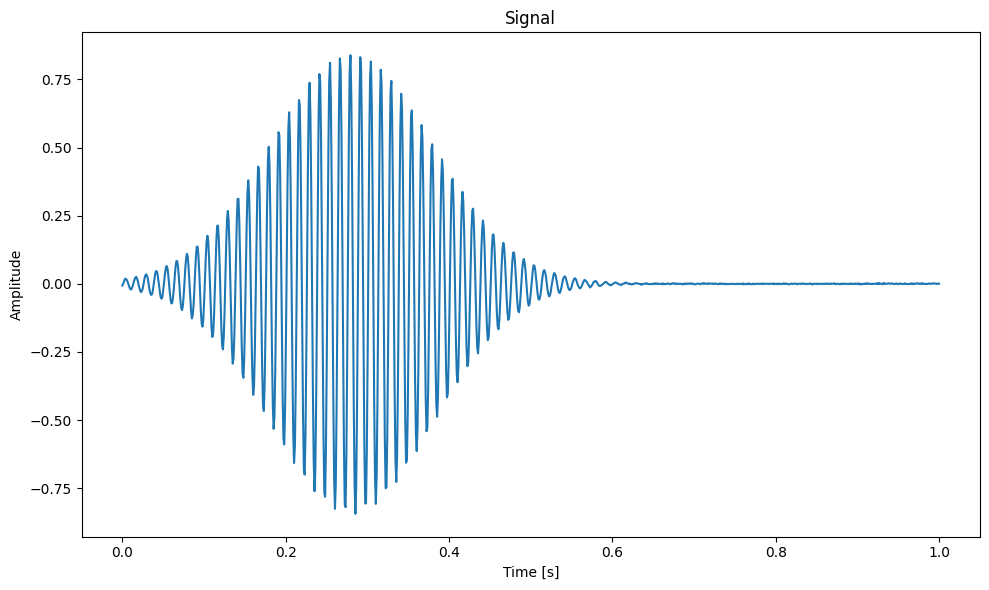

In [10]:
fs = 1000
t = np.linspace(0, 1, fs)

# plot 10 samples of samples_0 and samples_1
plt.figure(figsize=(10, 6))
for i in range(1):
    # plot all the samples in the same figure
    plt.plot(t, samples_0[i], label=f"sample {i}")
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
# plt.legend()
plt.tight_layout()

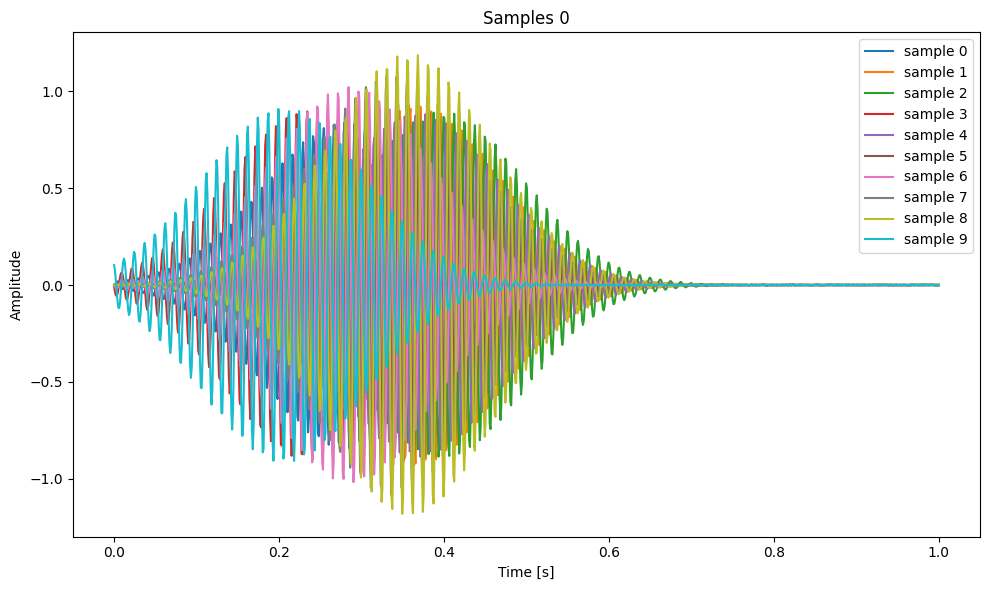

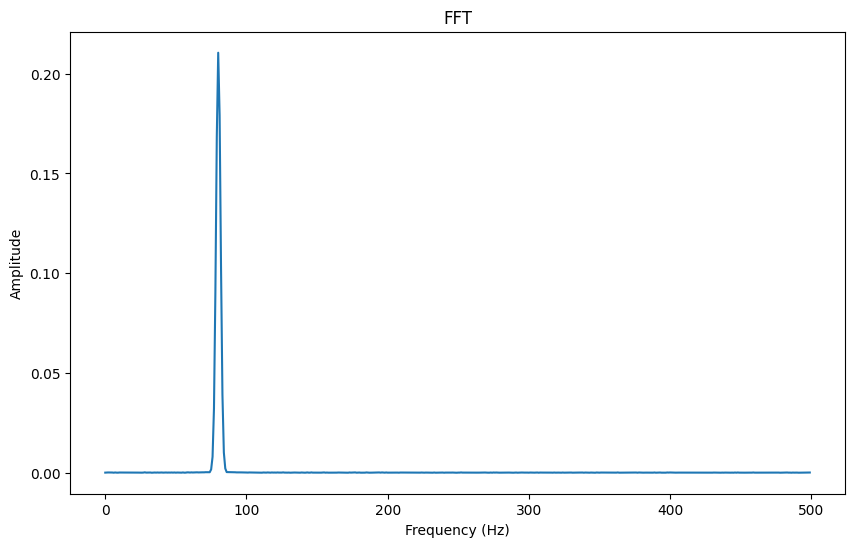

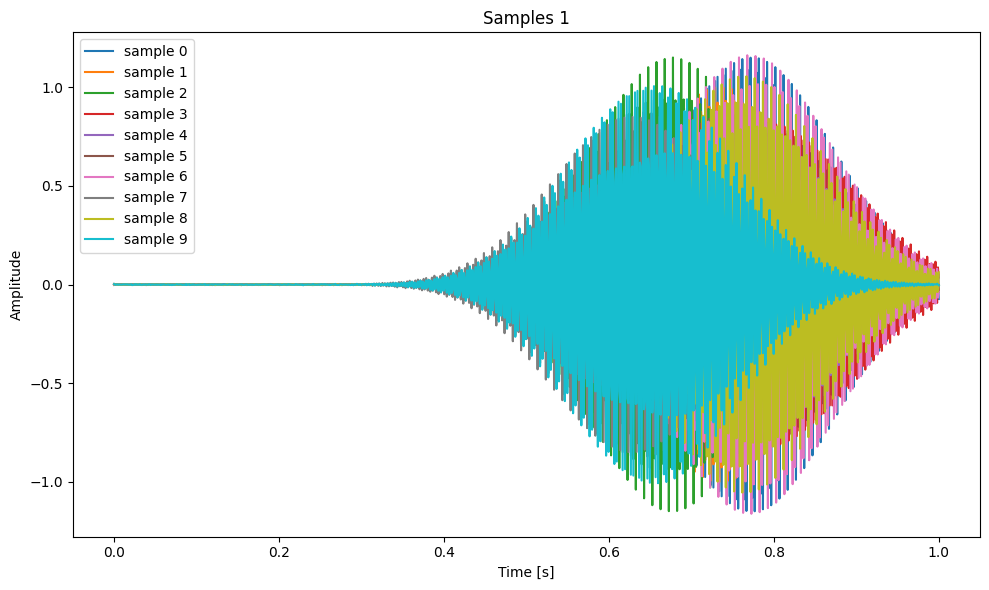

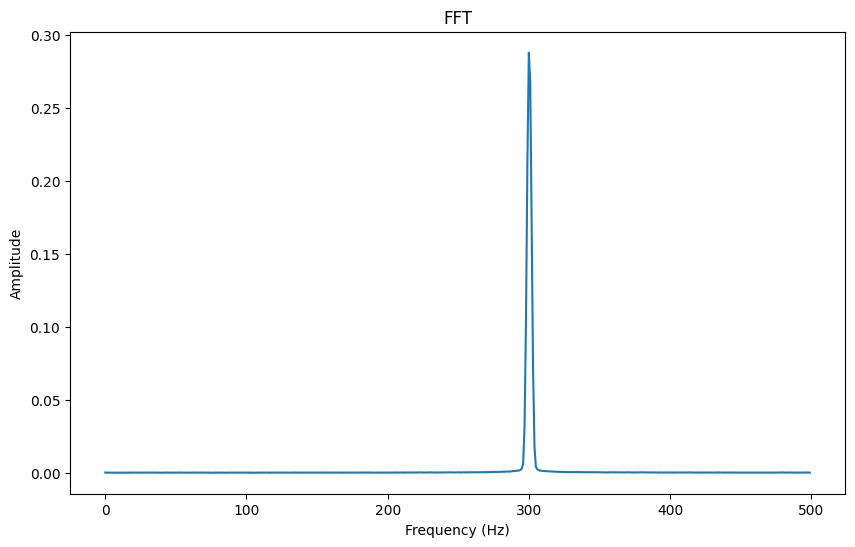

In [11]:
fs = 1000
t = np.linspace(0, 1, fs)

# plot 10 samples of samples_0 and samples_1
plt.figure(figsize=(10, 6))
for i in range(10):
    # plot all the samples in the same figure
    plt.plot(t, samples_0[i], label=f"sample {i}")
plt.title("Samples 0")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()

plot_fft(samples_0[0], fs)

plt.figure(figsize=(10, 6))
for i in range(10):
    # plot all the samples in the same figure
    plt.plot(t, samples_1[i], label=f"sample {i}")
plt.title("Samples 1")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()

plot_fft(samples_1[0], fs)



In [12]:
# plot scaleograms

def plot_dwt_scaleogram(coeffs, w='db1', fs=16, label=0):
    """
    coeffs: list of coefficients
    fs: sampling frequency
    """
    # Create a figure
    plt.figure(figsize=(10, 6))

    # compute the frequency bands
    freq_bands = [fs / (2 ** (j + 1)) for j in range(len(coeffs[0]))]   # bands
    freq_bands.append(0)                                             # lowest frequency
    freq_bands = freq_bands[::-1]                                    # reverse the order
    
    scaleogram = np.array(coeffs)
    # scaleogram = scaleogram[:, :]
    scaleogram = np.abs(scaleogram)
    
    # normalize the scaleogram
    scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)

    # Create a meshgrid for time and frequency
    time = np.linspace(0, 1, fs)
    time = np.concatenate([time, [time[-1] + (1/fs)]])

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, scaleogram.T, shading='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f'Scaleogram of class {label} of wavelet {w}')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    plt.tight_layout()
    plt.show()

In [15]:
coeffs_0 = []
coeffs_1 = []

for i in range(10):
    coeffs_0.append(pywt.wavedec(samples_0[i], wavelet='coif5', level=5))
    coeffs_1.append(pywt.wavedec(samples_1[i], wavelet='coif5', level=5))

print(len(coeffs_0))
print(len(coeffs_1))

10
10


<Figure size 1000x600 with 0 Axes>

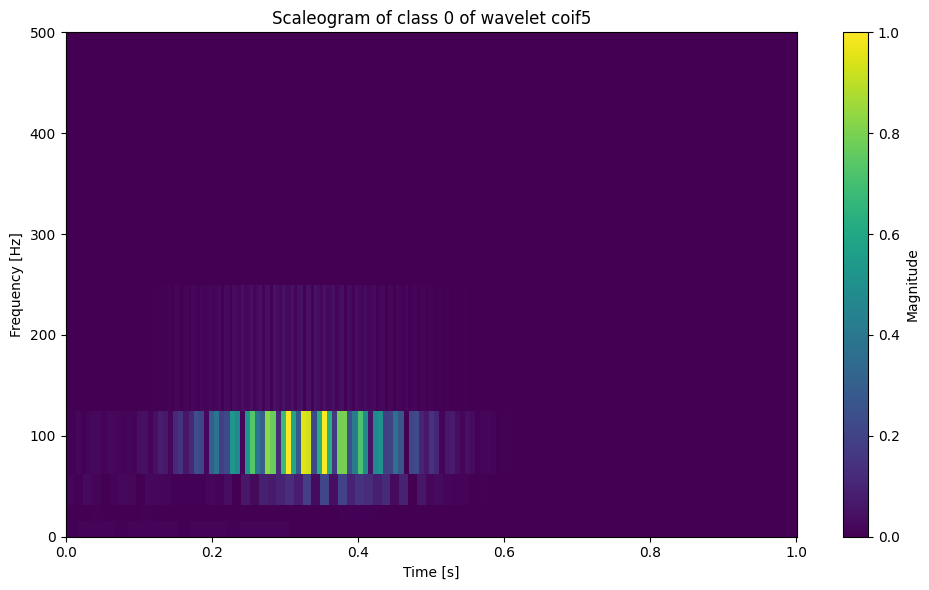

<Figure size 1000x600 with 0 Axes>

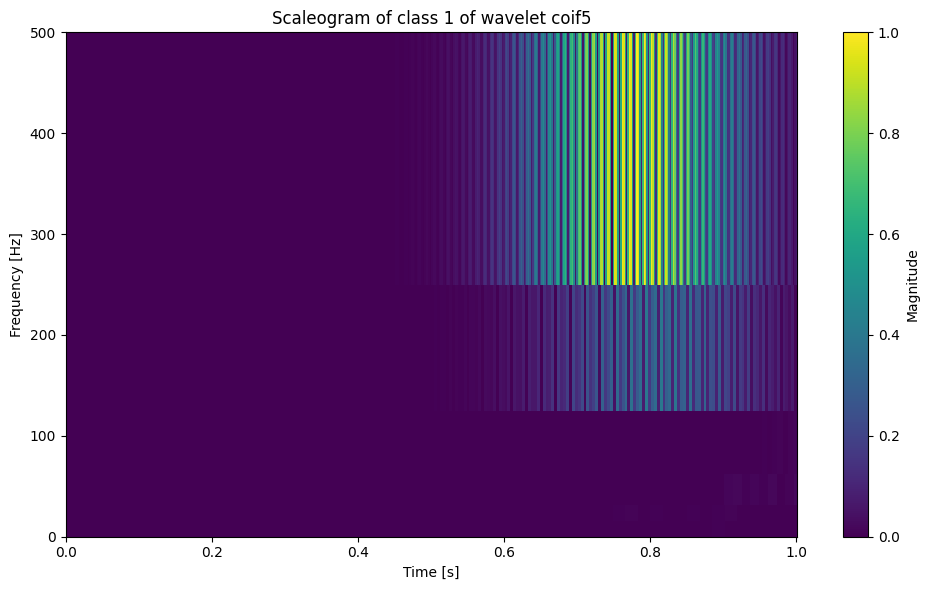

In [16]:
for i in range(1):
    bands_0 = upsampling_wavedec(fs, coeffs_0[i])
    plot_dwt_scaleogram(bands_0.T, 'coif5', fs=fs, label=0)

    bands_1 = upsampling_wavedec(fs, coeffs_1[i])
    plot_dwt_scaleogram(bands_1.T, 'coif5', fs=fs, label=1) 

In [18]:
# evaluate wavelet
fs = 1000
batch_size = 128
wavelet = 'coif'
w_len = 5
level = pywt.dwt_max_level(fs, 'coif5')
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)
print(level)

wavelet_coif5_5_128
5


In [19]:
def apply_dwt_filterbank_(data, fs, wavelet):
        """
        Apply the wavelet filterbank to the data.

        Parameters
        ----------
        data : np.ndarray or torch.Tensor
            Input data to be transformed. If a torch tensor is provided, it will be converted to numpy.
        """
        if isinstance(data, torch.Tensor):
            data = data.detach().cpu().numpy()
        else:
            data = data
        time = np.linspace(0, len(data) / fs, len(data))

        coeffs = pywt.wavedec(data, wavelet)

        return coeffs, time

In [20]:
import torch
import numpy as np
from src.attribution.wavelet.wavelet import WaveletFilterbank
from src.utils.sampling import downsample_wavedec, upsampling_wavedec

class WaveletMask:
    def __init__(self, model, wavelet_filterbank: WaveletFilterbank, regularization='l1', device='cpu'):
        self.model = model.to(device)
        self.filterbank = wavelet_filterbank
        self.device = device
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.regularization = regularization
        self.nbanks = 5

    def fit(self,
            data,
            n_epoch: int = 10,
            learning_rate: float = 1.0e-2,
            keep_ratio: float = 0.01,
            reg_factor_init: float = 1.0,
            reg_factor_dilation: float = 1.0,
            stopping: float = 1.0e-5,
            patience: int = 10,
            verbose: bool = True,
            use_only_max: bool = True):
        
        self.model.eval()
        early_stopping_counter = 0

        data = data.float().to(self.device)

        # Get model target
        with torch.no_grad():
            target = self.model(data)
            target = torch.nn.functional.softmax(target, dim=1)
            if use_only_max:
                target = torch.argmax(target, dim=1)

        

        # Initialize mask
        mask_shape = torch.tensor(data.shape)
        mask = (0.1 * torch.ones((*mask_shape, self.nbanks), device=self.device)).detach()
        mask.requires_grad_()

        # print(f"Mask init: {mask}")

        optimizer = torch.optim.Adam([mask], lr=learning_rate)

        # Regularization
        if self.regularization == 'ratio':
            reg_ref = torch.zeros(int((1 - keep_ratio) * self.nbanks))
            reg_ref = torch.cat((reg_ref, torch.ones(self.nbanks - reg_ref.shape[0]))).to(self.device)

        # Get filtered bands from wavelet filterbank
        # print(f"bands now")
        # bands = upsampling_wavedec(16, coeffs)
        # plot_dwt_scaleogram(bands.T, 'db1', 16)


        bands = self.filterbank.get_wavelet_bands()
        bands = torch.tensor(bands).float().to(self.device) # (n_channels, time, n_filters)
        print(f"bands shape: {bands.shape}")
        bands = bands.permute(1, 0)
        bands = bands.unsqueeze(0)
        print(f"bands reshaped: {bands.shape}")

        reg_strength = reg_factor_init
        reg_multiplicator = np.exp(np.log(reg_factor_dilation) / max(n_epoch, 1))
        # print(f"Reg strength: {reg_strength}")
        # print(f"Reg multiplicator: {reg_multiplicator}")

        prev_loss = float('inf')
        total_loss = []

        for epoch in range(n_epoch):
            optimizer.zero_grad()
            # Apply mask and sum
            masked = (bands * mask).sum(-1)
            # plot the mask
            # plt.plot(mask.squeeze().detach().cpu().numpy())
            # plt.title("Mask")
            # plt.show()

            # print(f"Bands")
            # plot_dwt_scaleogram(bands.squeeze().detach().cpu().numpy(), 'coif5', 1000)

            # print('reconstructed')
            # print(masked.shape)
            # plt.plot(masked.squeeze().detach().cpu().numpy())
            # plt.title("Reconstructed")
            # plt.show()

            # print(f"Masked")
            # plot_dwt_scaleogram(masked.squeeze().detach().cpu().numpy(), 'coif5', 1000)

            # masked = masked.sum(-1)
            # # masked = bands * mask
            # plt.plot(masked.squeeze().detach().cpu().numpy())
            # plt.title("Masked")
            # plt.show()

            # move last axis to the first
            # masked = masked.squeeze()
            # masked = masked.permute(1, 0)
            # downsample = downsample_wavedec(len(masked[0]), masked.detach().cpu().numpy(), 'coif5', 5)
            # s = pywt.waverec(downsample, 'coif5')
            # make it a torch tensor
            # masked = torch.tensor(s).float().to(self.device)
            # plt.plot(s)
            # plt.title("Masked signal reconstructed")
            # plt.show()
            
            # masked = masked.unsqueeze(0)
            # print(masked.shape)
            
            # print(f"Masked: {masked}")
            output = self.model(masked)
            # print(f"Output: {output}")
            output = torch.nn.functional.softmax(output, dim=1)
            # print(f"Output softmax: {output}")
            target_loss = self.loss_fn(output, target)

            # Compute regularization
            if self.regularization == 'l1':
                reg_loss = torch.max(mask.abs().mean() - keep_ratio, torch.tensor(0., device=self.device))
            elif self.regularization == 'l2':
                reg_loss = mask.pow(2).mean()
            elif self.regularization == 'ratio':
                reg_loss = ((torch.sort(mask)[0] - reg_ref)**2).mean()
            else:
                reg_loss = 0.0

            loss = target_loss + reg_strength * reg_loss
            loss.backward()
            optimizer.step()

            # Clamp mask to [0, 1]
            mask.data = torch.clamp(mask, 0, 1)
            total_loss.append(loss.item())

            reg_strength *= reg_multiplicator

            if verbose and epoch % 10 == 0:
                print(f'Epoch {epoch}: Loss={loss.item():.4f}, Target={target_loss.item():.4f}, Reg={reg_loss.item():.4f}')

            # Early stopping
            if abs(prev_loss - total_loss[-1]) < stopping:
                early_stopping_counter += 1
            else:
                early_stopping_counter = 0
            prev_loss = total_loss[-1]
            if early_stopping_counter > patience:
                break

            break
            

        return mask, total_loss



In [21]:
import torch
import numpy as np
from src.utils.sampling import upsampling_wavedec


def compute_wavelet_attribution( model, 
                                 dataloader, 
                                 filterbank_params = {'wavelet': 'db', 'w_len': 1, 'fs': 16, 'level': 4}, 
                                 device:str = 'cpu', 
                                 verbose:bool = True,
                                 regularization:str = 'l1'):
    # define mask
    masks = []
    scores = []
    losses = []

    # create filterbank
    filterbank = WaveletFilterbank(**filterbank_params)

    # create FLEXtime mask
    mask_opt = WaveletMask(model, filterbank, device=device, regularization=regularization) 

    for i, batch in enumerate(dataloader):
        batch_scores = []
        filter_batch_scores = []

        # compute the batch scores
        print(f"Batch {i} of {len(dataloader)}")

        for j, (x, y) in enumerate(zip(*batch)):
            print(f"Sample {j} of {len(batch[0])}")

            x = x.to(device)
            y = y.to(device)

            # computing the wavelet transform for the target sequence
            signal = x[0]

            # plt.plot(signal.detach().cpu().numpy())
            # plt.title("Signal")
            # plt.show()

            # test = pywt.wavedec(signal.detach().cpu().numpy(), 'db1')
            # upsampled = upsampling_wavedec(16, test)
            # plot_dwt_scaleogram(upsampled.T, 'db1', 16)

            # create filterbank assuming 1 channel
            filterbank.apply_dwt_filterbank(signal)
            # coeffs, time = apply_dwt_filterbank_(signal, fs, 'coif5')
            
            # get the attribution mask
            mask, loss = mask_opt.fit(x, verbose=verbose)
            # print(type(mask))

            losses.append(loss)
            mask = mask.squeeze().cpu().detach().numpy() # shape (time, n_filters)
            # print(f"Mask shape: {mask.shape}")

            # normalize 
            imp = torch.tensor(filterbank.get_filter_response(mask)) # shape (channels, time, n_filters)
            # print(f"Imp shape: {imp.shape}")

            batch_scores.append(imp)
            filter_batch_scores.append(mask)

        # store the data
        masks.append(torch.stack(batch_scores)) # shape (batch_len, channels, time, n_filters)
        scores.append(np.stack(filter_batch_scores))  # shape (batch_len, time, n_filters)

        break

    return masks, scores, losses, y

In [22]:
# set_seed(42)

masks, scores, losses, y = compute_wavelet_attribution(model, test_loader, device = device)

Batch 0 of 79
Sample 0 of 128
bands shape: torch.Size([5, 1000])
bands reshaped: torch.Size([1, 1000, 5])
Epoch 0: Loss=1.3944, Target=1.3044, Reg=0.0900
Sample 1 of 128
bands shape: torch.Size([5, 1000])
bands reshaped: torch.Size([1, 1000, 5])
Epoch 0: Loss=1.3951, Target=1.3051, Reg=0.0900
Sample 2 of 128
bands shape: torch.Size([5, 1000])
bands reshaped: torch.Size([1, 1000, 5])
Epoch 0: Loss=0.4043, Target=0.3143, Reg=0.0900
Sample 3 of 128
bands shape: torch.Size([5, 1000])
bands reshaped: torch.Size([1, 1000, 5])
Epoch 0: Loss=0.4043, Target=0.3143, Reg=0.0900
Sample 4 of 128
bands shape: torch.Size([5, 1000])
bands reshaped: torch.Size([1, 1000, 5])
Epoch 0: Loss=1.3945, Target=1.3045, Reg=0.0900
Sample 5 of 128
bands shape: torch.Size([5, 1000])
bands reshaped: torch.Size([1, 1000, 5])
Epoch 0: Loss=0.4043, Target=0.3143, Reg=0.0900
Sample 6 of 128
bands shape: torch.Size([5, 1000])
bands reshaped: torch.Size([1, 1000, 5])
Epoch 0: Loss=0.4043, Target=0.3143, Reg=0.0900
Sample

In [23]:
print(masks[0][0])
print(scores[0][0])

tensor([[[5.7659e-06, 7.8571e-06, 1.1506e-05, 4.0266e-05, 1.2866e-04],
         [5.7659e-06, 7.8571e-06, 1.1506e-05, 4.0266e-05, 1.2866e-04],
         [5.7659e-06, 7.8571e-06, 1.1506e-05, 4.0266e-05, 5.5551e-05],
         ...,
         [1.6491e-04, 0.0000e+00, 2.5170e-04, 4.4086e-04, 6.2215e-03],
         [1.6491e-04, 0.0000e+00, 2.5170e-04, 4.4086e-04, 6.2947e-03],
         [1.6491e-04, 0.0000e+00, 2.5170e-04, 4.4086e-04, 6.2947e-03]]])
[[0.0900005  0.0900005  0.0900005  0.0900005  0.0900005 ]
 [0.0900005  0.0900005  0.0900005  0.0900005  0.0900005 ]
 [0.0900005  0.0900005  0.0900005  0.0900005  0.0900005 ]
 ...
 [0.09000053 0.0900005  0.0900005  0.09000051 0.09000055]
 [0.09000048 0.0900005  0.09000051 0.0900005  0.09000057]
 [0.09000051 0.0900005  0.0900005  0.0900005  0.09000048]]


In [22]:
print(masks[0][0])
print(scores[0][0])

tensor([[[0.0000e+00, 3.1764e-04, 4.8125e-04, 4.9103e-05, 6.9115e-05],
         [0.0000e+00, 3.1764e-04, 4.8125e-04, 4.9103e-05, 6.9115e-05],
         [0.0000e+00, 3.1764e-04, 4.8125e-04, 4.9103e-05, 1.2195e-05],
         [0.0000e+00, 3.1764e-04, 4.8125e-04, 4.9103e-05, 1.2195e-05],
         [0.0000e+00, 3.1764e-04, 4.8125e-04, 1.3143e-03, 2.8572e-05],
         [0.0000e+00, 3.1764e-04, 4.8125e-04, 1.3143e-03, 2.8572e-05],
         [0.0000e+00, 3.1764e-04, 4.8125e-04, 1.3143e-03, 4.2463e-03],
         [0.0000e+00, 3.8822e-04, 4.8125e-04, 1.3143e-03, 4.2463e-03],
         [0.0000e+00, 3.1764e-04, 7.1790e-03, 3.6536e-02, 1.1000e-01],
         [0.0000e+00, 3.1764e-04, 7.1790e-03, 3.6536e-02, 1.1000e-01],
         [0.0000e+00, 3.8823e-04, 5.8737e-03, 4.4655e-02, 6.3324e-02],
         [0.0000e+00, 3.1764e-04, 7.1790e-03, 3.6536e-02, 7.7397e-02],
         [0.0000e+00, 3.8823e-04, 5.8737e-03, 2.7955e-03, 9.2603e-02],
         [0.0000e+00, 3.8823e-04, 5.8737e-03, 2.7955e-03, 9.2603e-02],
      

In [24]:
def plot_scaleogram_wav_heatmap(signal, attribution, prediction:int, label:int, fs=1000, wavelet='db1' ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(len(attribution[0]))]   # bands
    freq_bands.append(0)                                        # lowest frequency
    freq_bands = freq_bands[::-1]                               # reverse the order
    # print(freq_bands)

    time = np.linspace(0, signal / fs, signal)
    

    # normalize attribution scores to [0,1]
    attribution = np.abs(attribution)
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attr_norm[1:,:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'Attributions of class {label} learned through wavelet {wavelet}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [25]:
print(len(scores))
print(len(scores[0]))
print(len(scores[0][0]))


1
128
1000


wavelet_coif5_5_128


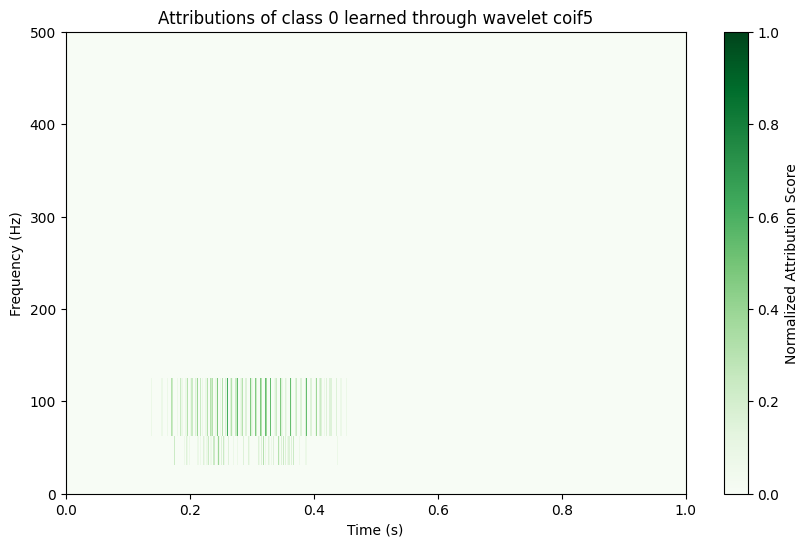

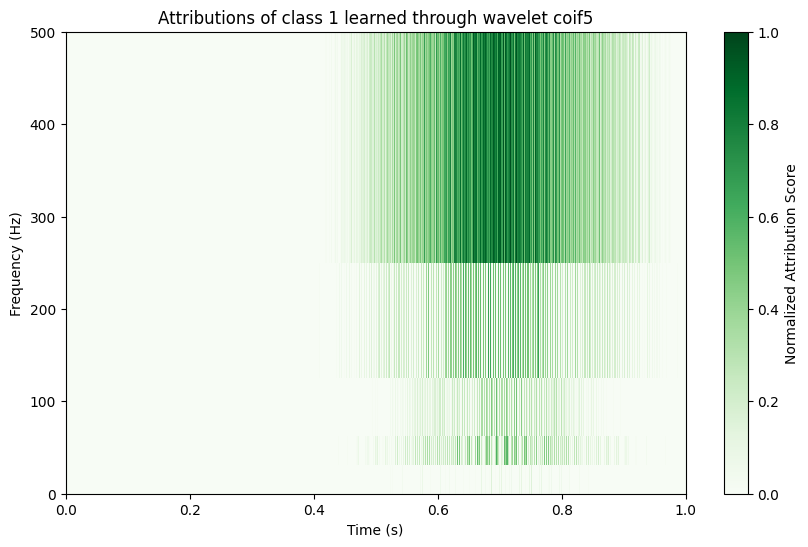

Counts of label 0: 61, label 1: 67
Shape of mask 0: (1000, 5), mask 1: (1000, 5)


In [26]:
counts_0 = 0
counts_1 = 0

attributions['insertion']['wavelet_coif5_5_128'] = scores

set_seed(42)

for key in attributions['insertion'].keys():
    print(key)

    method, wavelet, max_level, batch_size = key.split('_')
    max_level = int(max_level)

    masks_0 = np.zeros_like(scores[0][0])
    masks_1 = np.zeros_like(scores[0][0])

    index = 0

    for i, batch in enumerate(test_loader):
        x, y = batch

        for j in range(len(scores[i])):
            # print(index)
            if y[j] == 0:
                counts_0 += 1
                masks_0 += scores[i][j]
            else:
                counts_1 += 1
                masks_1 += scores[i][j]

            index += 1
        break

    masks_0 /= counts_0
    masks_1 /= counts_1

    plot_scaleogram_wav_heatmap(fs, masks_0, prediction=0, label=0, fs=fs, wavelet='coif5')
    plot_scaleogram_wav_heatmap(fs, masks_1, prediction=1, label=1, fs=fs, wavelet='coif5')
    
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}")
print(f"Shape of mask 0: {masks_0.shape}, mask 1: {masks_1.shape}")

Counts of label 0: 5000, label 1: 5000
1
1
2
4
8


<Figure size 1000x600 with 0 Axes>

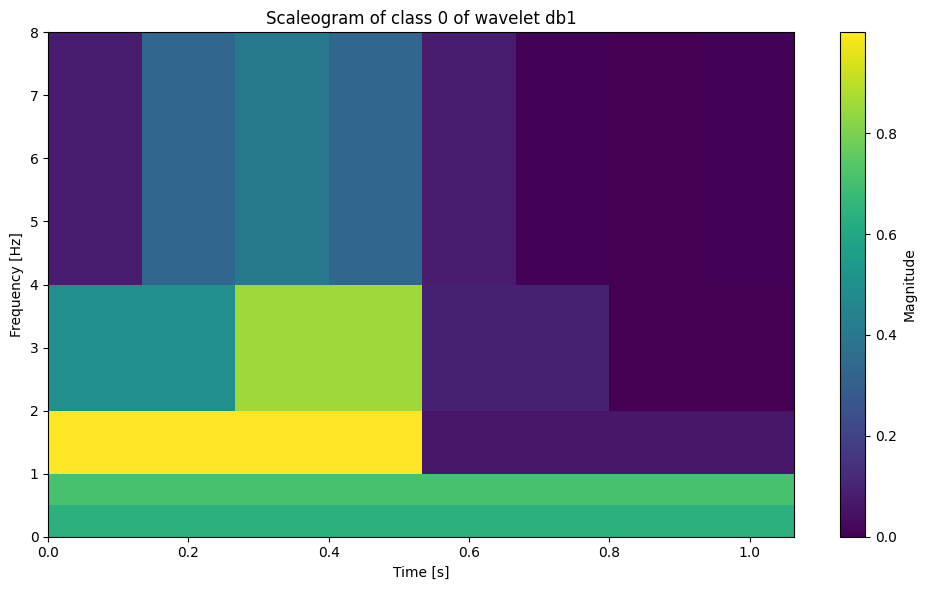

<Figure size 1000x600 with 0 Axes>

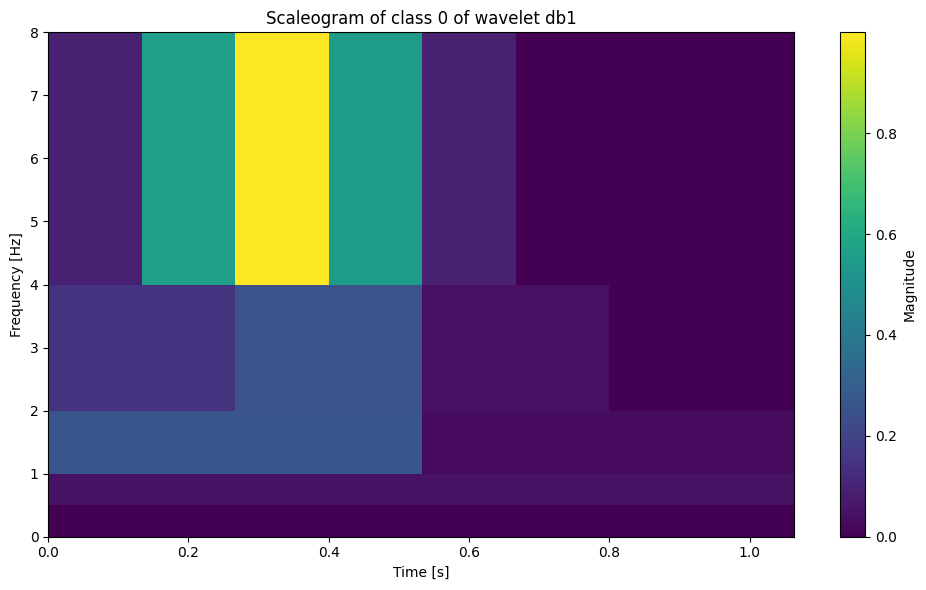

In [301]:
from src.utils.sampling import upsampling_wavedec

counts_0 = 0
counts_1 = 0

wavelets_0 = np.zeros((5, 16))
wavelets_1 = np.zeros((5, 16))

for batch in test_loader:
    x, y = batch
    
    for i, channels in enumerate(x):
        signal = channels[0].detach().cpu().numpy()

        coeffs = pywt.wavedec(signal, 'db1', level=4)
        upsampled = upsampling_wavedec(len(signal), coeffs)
        upsampled = np.abs(upsampled)

        if y[i] == 0:
            counts_0 += 1
            wavelets_0 += upsampled
        else:
            counts_1 += 1
            wavelets_1 += upsampled
    
wavelets_0 /= counts_0
wavelets_1 /= counts_1
    
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}")

for c in coeffs:
    print(len(c))

upsampled = upsampling_wavedec(len(signal), coeffs)
downsampled = downsample_wavedec(len(signal), coeffs, 'db1', 1)

plot_dwt_scaleogram(wavelets_0.T, fs=fs)
plot_dwt_scaleogram(wavelets_1.T, fs=fs)

#sc_same_time_0

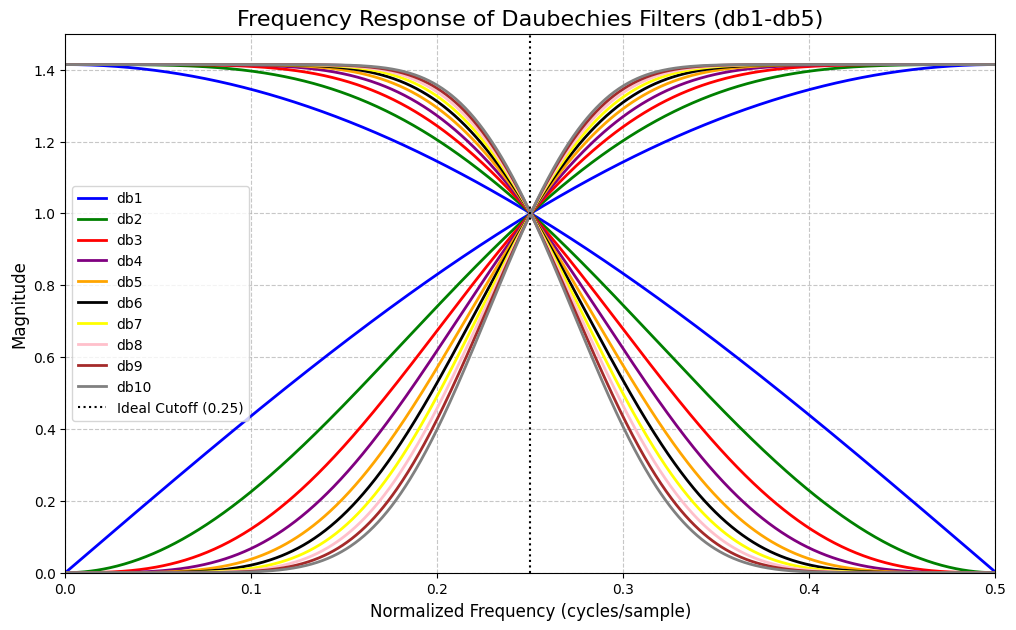

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Create a figure to hold the plot
fig, ax = plt.subplots(figsize=(12, 7))

colors = ['blue', 'green', 'red', 'purple', 'orange', 'black', 'yellow', 'pink', 'brown', 'gray']

# Define the number of points for the FFT (frequency analysis)
# A higher number gives a smoother curve
n_points = 2048 

# Loop through Daubechies wavelets from db1 to db5
for n in range(1, 11):
    wavelet_name = f'db{n}'
    
    # Get the wavelet object
    try:
        wavelet = pywt.Wavelet(wavelet_name)
    except ValueError:
        print(f"Wavelet {wavelet_name} not found.")
        continue
        
    # Get the low-pass decomposition filter coefficients
    # This is the impulse response of the filter
    low_pass_filter = wavelet.dec_lo
    high_pass_filter = wavelet.dec_hi
    
    # --- Compute the Frequency Response ---
    # We use the Fast Fourier Transform (FFT) on the filter coefficients.
    # We pad the filter with zeros up to n_points for a high-resolution frequency plot.
    l = np.fft.fft(low_pass_filter, n_points)
    h = np.fft.fft(high_pass_filter, n_points)
    
    # The result of FFT is symmetric, so we only need the first half
    magnitude_1 = np.abs(l[0:n_points//2])
    magnitude_2 = np.abs(h[0:n_points//2])

    
    # Create the corresponding frequency axis (normalized from 0 to 0.5)
    # 0.5 corresponds to the Nyquist frequency
    frequency_axis = np.linspace(0, 0.5, n_points//2)

    # Plot the frequency response for the current wavelet
    ax.plot(frequency_axis, magnitude_1, label=wavelet_name, lw=2, color=colors[n-1])
    ax.plot(frequency_axis, magnitude_2, lw=2, color=colors[n-1])

# --- Formatting the Plot ---
ax.set_title("Frequency Response of Daubechies Filters (db1-db5)", fontsize=16)
ax.set_xlabel("Normalized Frequency (cycles/sample)", fontsize=12)
ax.set_ylabel("Magnitude", fontsize=12)
ax.legend(title="Wavelet Family", fontsize=10)
ax.grid(True, which='both', linestyle='--', alpha=0.7)
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 1.5) # db1 goes up to sqrt(2) which is ~1.414

# Add a vertical line at the ideal cutoff frequency (0.25) for reference
ax.axvline(0.25, color='k', linestyle=':', lw=1.5, label='Ideal Cutoff (0.25)')
ax.legend() # Re-call legend to include the new label

plt.show()

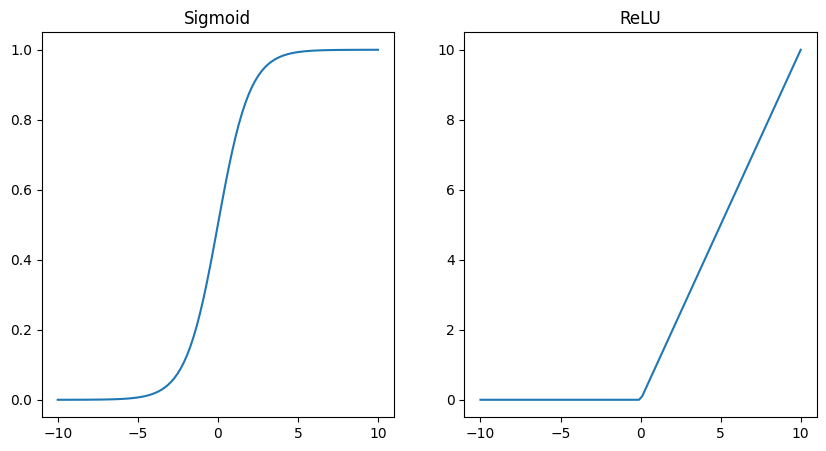

In [13]:
#plot the sigmoid function
import torch
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

x = torch.linspace(-10, 10, 100)
y = torch.sigmoid(x)
axes[0].plot(x, y)
axes[0].set_title('Sigmoid')

#plot the relu
x = torch.linspace(-10, 10, 100)
y = torch.relu(x)
axes[1].plot(x, y)
axes[1].set_title('ReLU')
plt.show()
